In [ ]:
#!pip install bert-tensorflow
#!pip show bert-tensorflow
#!pip install sacremoses
#!pip install transformers

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_venn as v
import seaborn as sns

from wordcloud import WordCloud

# bert
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import tensorflow_hub as hub
import tensorflow as tf
tf.gfile = tf.io.gfile
#import bert_tokenization as tokenization
from bert import tokenization
import tensorflow.keras.backend as K
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil

np.set_printoptions(suppress=True)

# distilbert
import sys
import glob
import torch
import transformers
from transformers import AutoTokenizer, AutoModelWithLMHead
import math
import re
import pickle  
import random
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Lambda
from keras.optimizers import Adam
from keras.callbacks import Callback
from scipy.stats import rankdata
from os.path import join as path_join
from numpy.random import seed
from urllib.parse import urlparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import MultiTaskElasticNet

seed(42)
tf.random.set_seed(42)
random.seed(42)

Using TensorFlow backend.


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
#train.head()
#test.head()
#sample_submission.head()

In [ ]:
output_categories = list(train.columns[11:])
input_categories = list(train.columns[[1,2,5]])

### Exploratory Data Analysis

In [ ]:
# summary statistics
print("Shape of Training dataset:", train.shape)
print("Shape of Test dataset:", test.shape)
print("Unique Categories in Training dataset:", len(train.category.unique()))
print("Unique Categories in Test dataset:", len(test.category.unique()))
print("Unique Hosts in Training dataset:", len(train.host.unique()))
print("Unique Hosts in Test dataset:", len(test.host.unique()))
print("Unique Questioners in Training dataset:", len(train.question_user_name.unique()))
print("Unique Questioners in Test dataset:", len(test.question_user_name.unique()))
print("Unique Answerers in Training dataset:", len(train.answer_user_name.unique()))
print("Unique Answerers in Test dataset:", len(test.answer_user_name.unique()))

Shape of Training dataset: (6079, 41)
Shape of Test dataset: (476, 11)
Unique Categories in Training dataset: 5
Unique Categories in Test dataset: 5
Unique Hosts in Training dataset: 63
Unique Hosts in Test dataset: 55
Unique Questioners in Training dataset: 3215
Unique Questioners in Test dataset: 467
Unique Answerers in Training dataset: 4114
Unique Answerers in Test dataset: 363


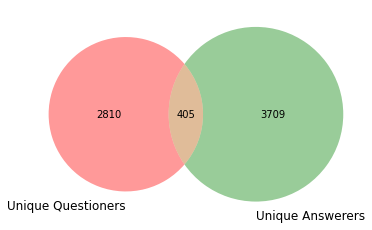

In [ ]:
# common users in both questions & answers
v.venn2([set(train.question_user_name.unique()), set(train.answer_user_name.unique())], set_labels = ('Unique Questioners', 'Unique Answerers') )

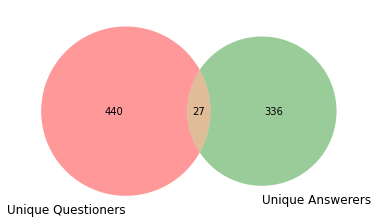

In [ ]:
# common users in both questions & answers
v.venn2([set(test.question_user_name.unique()), set(test.answer_user_name.unique())], set_labels = ('Unique Questioners', 'Unique Answerers') )

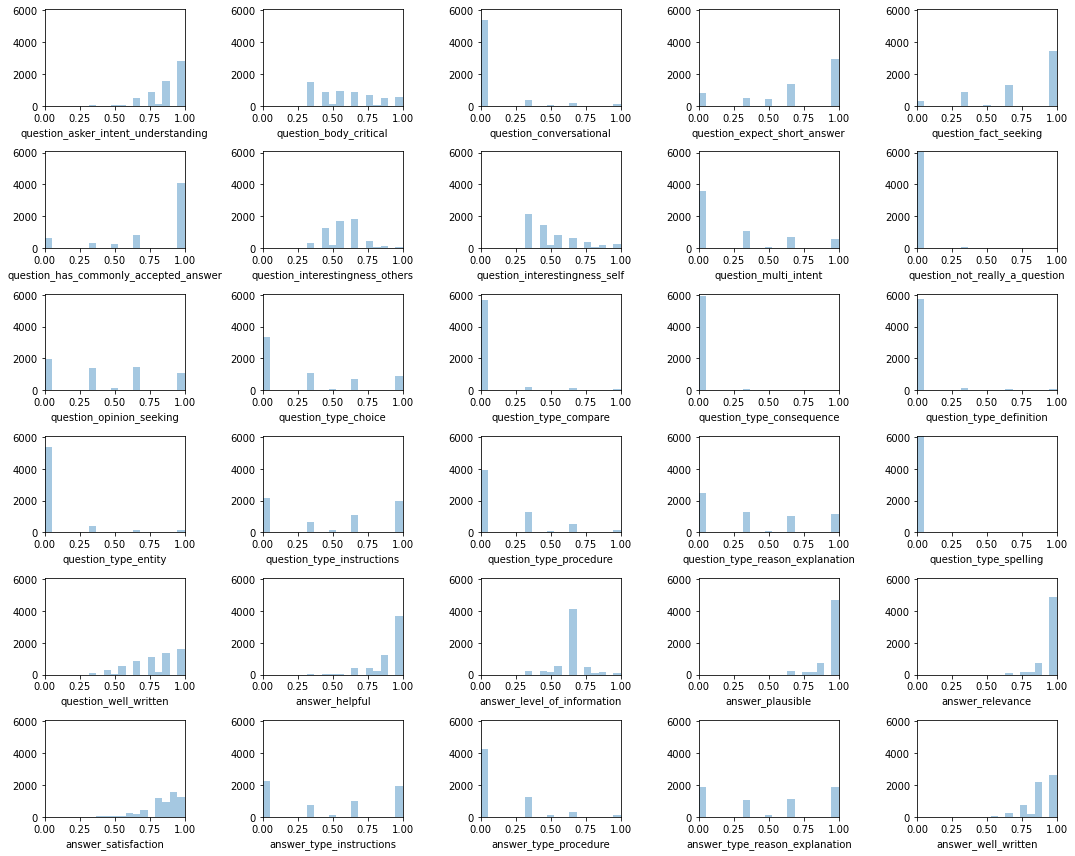

In [ ]:
# distribution of target labels in training data
fig, axes = plt.subplots(6, 5, figsize=(15, 12))
axes = axes.ravel()
bins = np.linspace(0, 1, 20)

for i, col in enumerate(sample_submission.columns[1:]):
    ax = axes[i]
    sns.distplot(train[col], label=col, kde=False, bins=bins, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 6079])
plt.tight_layout()
plt.show()
plt.close()

Training data Word Cloud
Test data Word Cloud


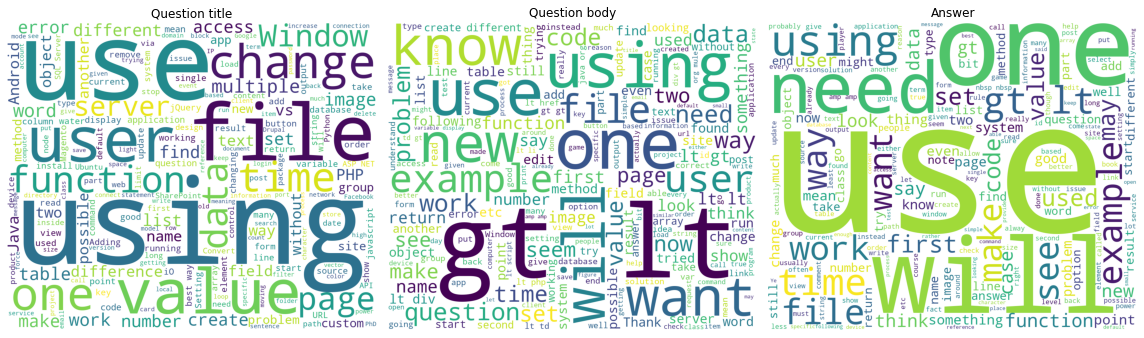

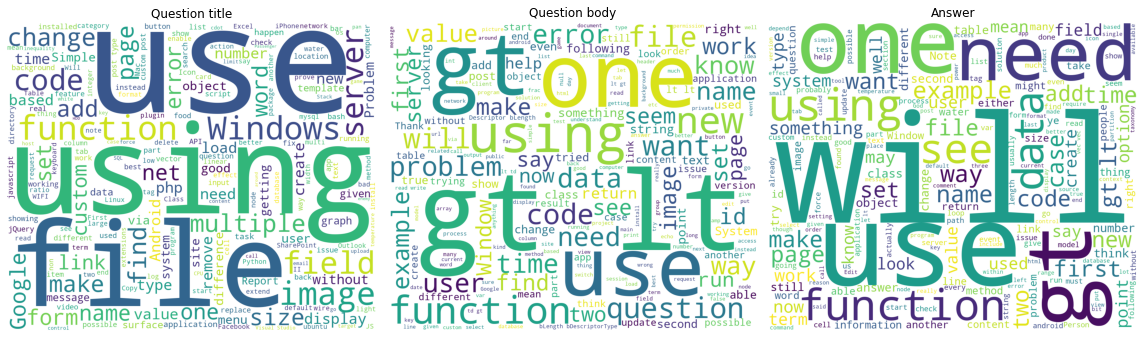

In [ ]:
# training and test data word cloud
def plot_wordcloud(text, ax, title=None):
    wordcloud = WordCloud(max_font_size=None, background_color='white',
                          width=1200, height=1000).generate(text_cat)
    ax.imshow(wordcloud)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")
    
print('Training data Word Cloud')

fig, axes = plt.subplots(1, 3, figsize=(16, 18))

text_cat = ' '.join(train['question_title'].values)
plot_wordcloud(text_cat, axes[0], 'Question title')

text_cat = ' '.join(train['question_body'].values)
plot_wordcloud(text_cat, axes[1], 'Question body')

text_cat = ' '.join(train['answer'].values)
plot_wordcloud(text_cat, axes[2], 'Answer')

plt.tight_layout()
fig.show()

print('Test data Word Cloud')

fig, axes = plt.subplots(1, 3, figsize=(16, 18))

text_cat = ' '.join(test['question_title'].values)
plot_wordcloud(text_cat, axes[0], 'Question title')

text_cat = ' '.join(test['question_body'].values)
plot_wordcloud(text_cat, axes[1], 'Question body')

text_cat = ' '.join(test['answer'].values)
plot_wordcloud(text_cat, axes[2], 'Answer')

plt.tight_layout()
fig.show()
# Train/Test high frequency words is similar

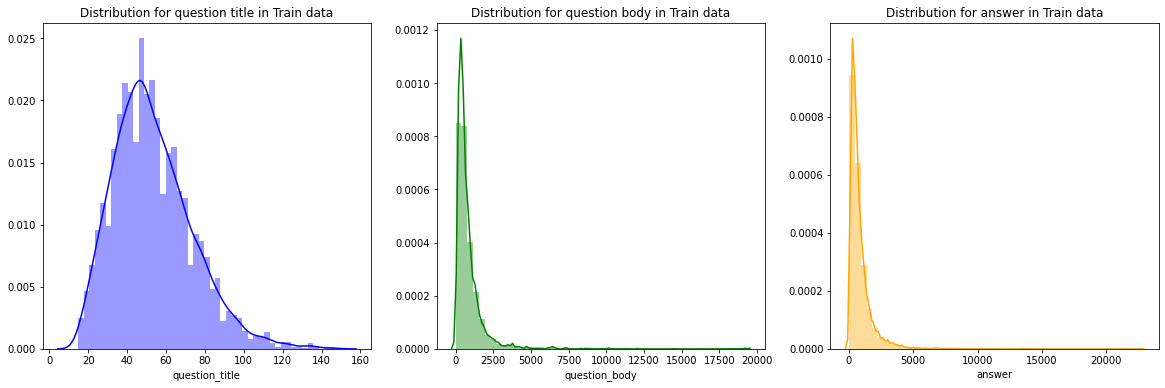

In [ ]:
# distribution of length of questions and answers in training data
train_question_title=train['question_title'].str.len()
train_question_body=train['question_body'].str.len()
train_answer=train['answer'].str.len()
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,6))
sns.distplot(train_question_title,ax=ax1,color='blue')
sns.distplot(train_question_body,ax=ax2,color='green')
sns.distplot(train_answer,ax=ax3,color='orange')
ax1.set_title('Distribution for question title in Train data')
ax2.set_title('Distribution for question body in Train data')
ax3.set_title('Distribution for answer in Train data')
plt.show()

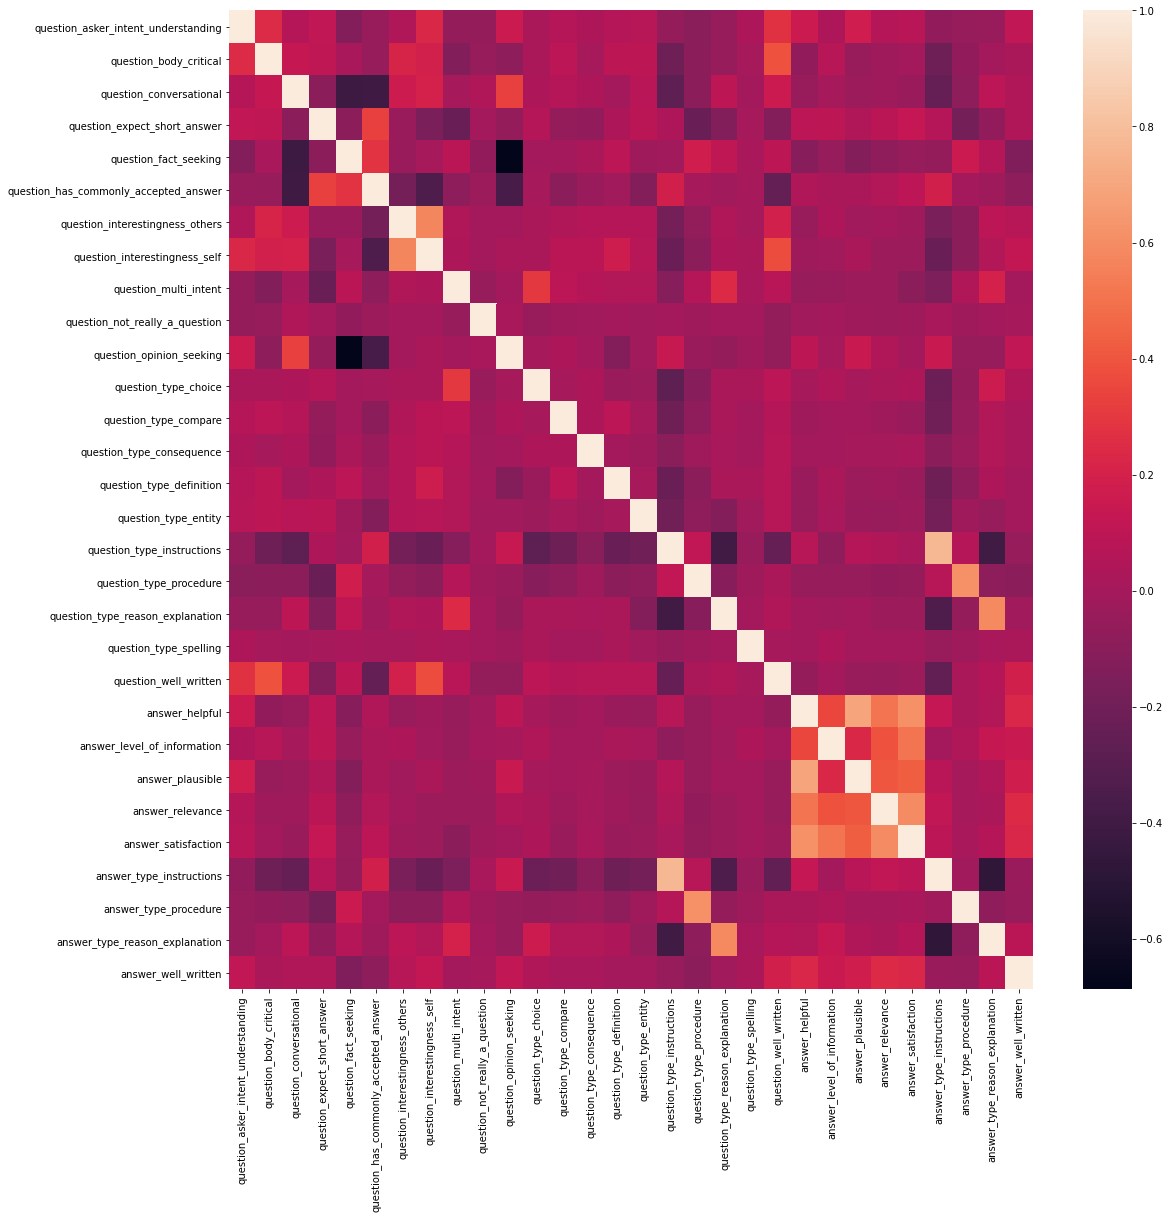

In [ ]:
# question target labels correlation plot
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train[sample_submission.columns[1:]].corr(), ax=ax)
# question labels and answer labels show high positive correlation for instruction type, procedure type and reason explanation type questions

### The BERT Model - Use TPU/ GPU on Google Colab



In [ ]:
# read tokenizer
max_seq_length = 512
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


In [ ]:
# preprocessing functions
def _get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    first_sep = True
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if first_sep:
                first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input(title, question, answer, max_seq_length, 
                t_max_len=30, q_max_len=239, a_max_len=239):

    t = tokenizer.tokenize(title)
    q = tokenizer.tokenize(question)
    a = tokenizer.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    a_len = len(a)

    if (t_len+q_len+a_len+4) > max_seq_length:
        
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
            
            
        if t_new_len+a_new_len+q_new_len+4 != max_seq_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_seq_length, (t_new_len+a_new_len+q_new_len+4)))
        
        t = t[:t_new_len]
        q = q[:q_new_len]
        a = a[:a_new_len]
    
    return t, q, a

def _convert_to_bert_inputs(title, question, answer, tokenizer, max_seq_length):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    stoken = ["[CLS]"] + title + ["[SEP]"] + question + ["[SEP]"] + answer + ["[SEP]"]

    input_ids = _get_ids(stoken, tokenizer, max_seq_length)
    input_masks = _get_masks(stoken, max_seq_length)
    input_segments = _get_segments(stoken, max_seq_length)

    return [input_ids, input_masks, input_segments]

def compute_input_arays(df, columns, tokenizer, max_seq_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        t, q, a = instance.question_title, instance.question_body, instance.answer

        t, q, a = _trim_input(t, q, a, max_seq_length)

        ids, masks, segments = _convert_to_bert_inputs(t, q, a, tokenizer, max_seq_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]


def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [ ]:
# create model
def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.mean(rhos)

def compute_spearmanr1(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return rhos


class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data, test_data, batch_size=16, fold=None):

        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.test_inputs = test_data
        
        self.batch_size = batch_size
        self.fold = fold
        
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        self.test_predictions = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.valid_predictions.append(
            self.model.predict(self.valid_inputs, batch_size=self.batch_size))
        
        rho_val = compute_spearmanr(
            self.valid_outputs, np.average(self.valid_predictions, axis=0))

        rho_val1 = compute_spearmanr1(
            self.valid_outputs, np.average(self.valid_predictions, axis=0))
                
        print("\nvalidation rho: %.4f" % rho_val)
        for elem in rho_val1:
            print("\nvalidation rho: %.4f" % elem)
        
        if self.fold is not None:
            self.model.save_weights(f'bert-base-{fold}-{epoch}.h5py')
        
        self.test_predictions.append(
            self.model.predict(self.test_inputs, batch_size=self.batch_size)
        )

def bert_model():
    
    input_word_ids = tf.keras.layers.Input(
        (max_seq_length,), dtype=tf.int32, name='input_word_ids')
    input_masks = tf.keras.layers.Input(
        (max_seq_length,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(
        (max_seq_length,), dtype=tf.int32, name='input_segments')
    
    bert_layer = hub.KerasLayer(BERT_PATH, trainable=True)
    
    _, sequence_output = bert_layer([input_word_ids, input_masks, input_segments])
    
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(30, activation="sigmoid", name="dense_output")(x)

    model = tf.keras.models.Model(
        inputs=[input_word_ids, input_masks, input_segments], outputs=out)
    
    return model    
        
def train_and_predict(model, train_data, valid_data, test_data, 
                      learning_rate, epochs, batch_size, loss_function, fold):
        
    custom_callback = CustomCallback(
        valid_data=(valid_data[0], valid_data[1]), 
        test_data=test_data,
        batch_size=batch_size,
        fold=None)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=optimizer)
    model.fit(train_data[0], train_data[1], epochs=epochs, 
              batch_size=batch_size, callbacks=[custom_callback])
    
    return custom_callback

In [ ]:
# obtain inputs and targets, as well as the indices of the train/validation splits
gkf = GroupKFold(n_splits=5).split(X=train.question_body, groups=train.question_body)

outputs = compute_output_arrays(train, output_categories)
inputs = compute_input_arays(train, input_categories, tokenizer, max_seq_length)
test_inputs = compute_input_arays(test, input_categories, tokenizer, max_seq_length)

In [ ]:
# training, validation and testing
histories = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    
    # will actually only do 3 folds (out of 5) to manage < 2h
    if fold < 3:
        K.clear_session()
        model = bert_model()

        train_inputs = [inputs[i][train_idx] for i in range(3)]
        train_outputs = outputs[train_idx]

        valid_inputs = [inputs[i][valid_idx] for i in range(3)]
        valid_outputs = outputs[valid_idx]

        # history contains two lists of valid and test preds respectively:
        #  [valid_predictions_{fold}, test_predictions_{fold}]
        history = train_and_predict(model, 
                          train_data=(train_inputs, train_outputs), 
                          valid_data=(valid_inputs, valid_outputs),
                          test_data=test_inputs, 
                          learning_rate=3e-5, epochs=4, batch_size=8,
                          loss_function='binary_crossentropy', fold=fold)

        histories.append(history)

Epoch 1/4
608/608 [==============================] - ETA: 0s - loss: 0.3971
validation rho: 0.3681

validation rho: 0.3466

validation rho: 0.5703

validation rho: 0.3539

validation rho: 0.2562

validation rho: 0.3290

validation rho: 0.3951

validation rho: 0.3012

validation rho: 0.4316

validation rho: 0.5134

validation rho: 0.0817

validation rho: 0.4187

validation rho: 0.7066

validation rho: 0.3357

validation rho: 0.1709

validation rho: 0.3702

validation rho: 0.5002

validation rho: 0.7690

validation rho: 0.3632

validation rho: 0.6278

validation rho: 0.0281

validation rho: 0.4216

validation rho: 0.2020

validation rho: 0.3503

validation rho: 0.0948

validation rho: 0.1217

validation rho: 0.2125

validation rho: 0.7447

validation rho: 0.2933

validation rho: 0.5914

validation rho: 0.1413
608/608 [==============================] - 379s 624ms/step - loss: 0.3971
Epoch 2/4
608/608 [==============================] - ETA: 0s - loss: 0.3685
validation rho: 0.3876

validat

### The DistilBERT Model - Use TPU/ GPU on Google Colab

In [ ]:
# preprocessing functions
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
def fetch_vectors(string_list, batch_size=64):
    # inspired by https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
    DEVICE = torch.device("cuda")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModelWithLMHead.from_pretrained("distilbert-base-uncased")
    model.to(DEVICE)

    fin_features = []
    for data in chunks(string_list, batch_size):
        tokenized = []
        for x in data:
            x = " ".join(x.strip().split()[:300])
            tok = tokenizer.encode(x, add_special_tokens=True)
            tokenized.append(tok[:512])

        max_len = 512
        padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized])
        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded).to(DEVICE)
        attention_mask = torch.tensor(attention_mask).to(DEVICE)

        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        features = last_hidden_states[0][:, 0, :].cpu().numpy()
        fin_features.append(features)

    fin_features = np.vstack(fin_features)
    return fin_features

In [ ]:
train_question_body_dense = fetch_vectors(train.question_body.values)
train_answer_dense = fetch_vectors(train.answer.values)

test_question_body_dense = fetch_vectors(test.question_body.values)
test_answer_dense = fetch_vectors(test.answer.values)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:798: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Token indices sequence length is longer than the specified maximum sequence length for this model (1412 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (708 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1042 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1060 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

In [ ]:
targets = [
        'question_asker_intent_understanding',
        'question_body_critical',
        'question_conversational',
        'question_expect_short_answer',
        'question_fact_seeking',
        'question_has_commonly_accepted_answer',
        'question_interestingness_others',
        'question_interestingness_self',
        'question_multi_intent',
        'question_not_really_a_question',
        'question_opinion_seeking',
        'question_type_choice',
        'question_type_compare',
        'question_type_consequence',
        'question_type_definition',
        'question_type_entity',
        'question_type_instructions',
        'question_type_procedure',
        'question_type_reason_explanation',
        'question_type_spelling',
        'question_well_written',
        'answer_helpful',
        'answer_level_of_information',
        'answer_plausible',
        'answer_relevance',
        'answer_satisfaction',
        'answer_type_instructions',
        'answer_type_procedure',
        'answer_type_reason_explanation',
        'answer_well_written'    
    ]

input_columns = ['question_title', 'question_body', 'answer']

In [ ]:
# features
find = re.compile(r"^[^.]*")

train['netloc'] = train['url'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])
test['netloc'] = test['url'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])

features = ['netloc', 'category']
merged = pd.concat([train[features], test[features]])
ohe = OneHotEncoder()
ohe.fit(merged)

features_train = ohe.transform(train[features]).toarray()
features_test = ohe.transform(test[features]).toarray()

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/4, Total size: 576.45MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/4'.


In [ ]:
embeddings_train = {}
embeddings_test = {}
for text in input_columns:
    print(text)
    train_text = train[text].str.replace('?', '.').str.replace('!', '.').tolist()
    test_text = test[text].str.replace('?', '.').str.replace('!', '.').tolist()
    
    curr_train_emb = []
    curr_test_emb = []
    batch_size = 4
    ind = 0
    while ind*batch_size < len(train_text):
        curr_train_emb.append(embed(train_text[ind*batch_size: (ind + 1)*batch_size])["outputs"].numpy())
        ind += 1
        
    ind = 0
    while ind*batch_size < len(test_text):
        curr_test_emb.append(embed(test_text[ind*batch_size: (ind + 1)*batch_size])["outputs"].numpy())
        ind += 1    
        
    embeddings_train[text + '_embedding'] = np.vstack(curr_train_emb)
    embeddings_test[text + '_embedding'] = np.vstack(curr_test_emb)
    
del embed
K.clear_session()
gc.collect()

In [ ]:
l2_dist = lambda x, y: np.power(x - y, 2).sum(axis=1)

cos_dist = lambda x, y: (x*y).sum(axis=1)

dist_features_train = np.array([
    l2_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    l2_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    l2_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding']),
    cos_dist(embeddings_train['question_title_embedding'], embeddings_train['answer_embedding']),
    cos_dist(embeddings_train['question_body_embedding'], embeddings_train['answer_embedding']),
    cos_dist(embeddings_train['question_body_embedding'], embeddings_train['question_title_embedding'])
]).T

dist_features_test = np.array([
    l2_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    l2_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    l2_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding']),
    cos_dist(embeddings_test['question_title_embedding'], embeddings_test['answer_embedding']),
    cos_dist(embeddings_test['question_body_embedding'], embeddings_test['answer_embedding']),
    cos_dist(embeddings_test['question_body_embedding'], embeddings_test['question_title_embedding'])
]).T

X_train = np.hstack([item for k, item in embeddings_train.items()] + [features_train, dist_features_train])
X_test = np.hstack([item for k, item in embeddings_test.items()] + [features_test, dist_features_test])
y_train = train[targets].values

In [ ]:
X_train = np.hstack((X_train, train_question_body_dense, train_answer_dense))
X_test = np.hstack((X_test, test_question_body_dense, test_answer_dense))

In [ ]:
# create model
# compatible with tensorflow backend
class SpearmanRhoCallback(Callback):
    def __init__(self, training_data, validation_data, patience, model_name):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.patience = patience
        self.value = -1
        self.bad_epochs = 0
        self.model_name = model_name

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        rho_val = np.mean([spearmanr(self.y_val[:, ind], y_pred_val[:, ind] + np.random.normal(0, 1e-7, y_pred_val.shape[0])).correlation for ind in range(y_pred_val.shape[1])])
        if rho_val >= self.value:
            self.value = rho_val
        else:
            self.bad_epochs += 1
        if self.bad_epochs >= self.patience:
            print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True
            #self.model.save_weights(self.model_name)
        print('\rval_spearman-rho: %s' % (str(round(rho_val, 4))), end=100*' '+'\n')
        return rho_val

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
def create_model():
    inps = Input(shape=(X_train.shape[1],))
    x = Dense(512, activation='elu')(inps)
    x = Dropout(0.2)(x)
    x = Dense(y_train.shape[1], activation='sigmoid')(x)
    model = Model(inputs=inps, outputs=x)
    model.compile(
        optimizer=Adam(lr=1e-4),
        loss=['binary_crossentropy']
    )
    model.summary()
    return model

In [ ]:
all_predictions = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)
for ind, (tr, val) in enumerate(kf.split(X_train)):
    X_tr = X_train[tr]
    y_tr = y_train[tr]
    X_vl = X_train[val]
    y_vl = y_train[val]
    
    model = create_model()
    model.fit(
        X_tr, y_tr, epochs=100, batch_size=32, validation_data=(X_vl, y_vl), verbose=True, 
        callbacks=[SpearmanRhoCallback(training_data=(X_tr, y_tr), validation_data=(X_vl, y_vl),
                                       patience=5, model_name=f'best_model_batch{ind}.h5')]
    )
    all_predictions.append(model.predict(X_test))
    
model = create_model()
model.fit(X_train, y_train, epochs=33, batch_size=32, verbose=False)
all_predictions.append(model.predict(X_test))
    
kf = KFold(n_splits=5, random_state=2019, shuffle=True)
for ind, (tr, val) in enumerate(kf.split(X_train)):
    X_tr = X_train[tr]
    y_tr = y_train[tr]
    X_vl = X_train[val]
    y_vl = y_train[val]
    
    model = MultiTaskElasticNet(alpha=0.001, random_state=42, l1_ratio=0.5)
    model.fit(X_tr, y_tr)
    all_predictions.append(model.predict(X_test))
    
model = MultiTaskElasticNet(alpha=0.001, random_state=42, l1_ratio=0.5)
model.fit(X_train, y_train)
all_predictions.append(model.predict(X_test))